# Imports

In [1]:
import numpy as np
import pandas as pd
import dowhy
import dowhy.datasets
import dowhy.plotter
from dowhy import CausalModel
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set_style("whitegrid")

# Define faps colours 
fapsgreen    = "#97C139"   # from (151,193,57)
fapsblue     = "#296193"   # from (41,97,147)
fapsdarkgray = "#5F5F5F"   # from (95,95,95)
darkgray     = "#CCCCCC"   # from (0.8,0.8,0.8) in 0-255 scale: (204,204,204)
lightgray    = "#E5E5E5"   # from (0.9,0.9,0.9) in 0-255 scale: (229,229,229)

# Set the random seed for reproducibility
np.random.seed(42)

# Load Dataset

In [2]:
df = pd.read_csv('./dataset.csv')

# Use only the designated columns
select_cols = []
select_cols.append('DXP_HoldingPressure1')
select_cols.append('E77_BarrelTemperatureZone6')
select_cols.append('E77_TransferStroke')
select_cols.append('E77_CushionVolume')
select_cols.append('E77_DosingTime')
select_cols.append('DXP_AreaCavityPressure')
select_cols.append('SCA_PartWeight')
select_cols.append('E77_CavityPressureMaximum')


# Meta columns
select_cols.append('MET_MachineCycleID')
select_cols.append('MET_MaterialName')

df = df[select_cols]

# Separate into materials
df = df[df['MET_MaterialName'] == 'PP']

df.drop(columns=['MET_MaterialName'], inplace=True)
df.drop(columns=['MET_MachineCycleID'], inplace=True)
df

,DXP_HoldingPressure1,E77_BarrelTemperatureZone6,E77_TransferStroke,E77_CushionVolume,E77_DosingTime,DXP_AreaCavityPressure,SCA_PartWeight,E77_CavityPressureMaximum
0,150.4,220.0,24.3045,10.29,10810.0,1840.3,97.56,89.0
1,150.4,220.0,24.3045,10.23,10810.0,1838.2,97.57,89.0
2,150.4,220.0,24.3045,10.38,10880.0,1783.4,97.52,85.0
3,150.4,220.0,24.3045,10.19,10970.0,1825.9,97.57,89.0
4,150.4,220.0,24.3045,10.38,10850.0,1775.2,97.50,85.0
...,...,...,...,...,...,...,...,...
298,150.0,262.0,27.8410,7.22,10890.0,3275.0,97.62,98.0
299,150.0,262.0,27.8410,7.23,10990.0,3234.9,97.57,98.0
300,149.9,262.0,27.8410,7.40,10970.0,3247.9,97.66,99.0
301,150.0,262.0,27.8410,7.40,11000.0,3285.7,97.69,99.0


# Normalize

In [3]:
# Min-max normalization
normalized_df = (df-df.min())/(df.max()-df.min())
norm_min = df.min()
norm_max = df.max()

df = normalized_df
df

,DXP_HoldingPressure1,E77_BarrelTemperatureZone6,E77_TransferStroke,E77_CushionVolume,E77_DosingTime,DXP_AreaCavityPressure,SCA_PartWeight,E77_CavityPressureMaximum
0,0.003318,0.000000,0.0,0.945260,0.304348,0.037940,0.123506,0.053571
1,0.003318,0.000000,0.0,0.937250,0.304348,0.037648,0.127490,0.053571
2,0.003318,0.000000,0.0,0.957276,0.365217,0.030015,0.107570,0.029762
3,0.003318,0.000000,0.0,0.931909,0.443478,0.035935,0.127490,0.053571
4,0.003318,0.000000,0.0,0.957276,0.339130,0.028873,0.099602,0.029762
...,...,...,...,...,...,...,...,...
298,0.000664,0.933333,1.0,0.535381,0.373913,0.237768,0.147410,0.107143
299,0.000664,0.933333,1.0,0.536716,0.460870,0.232182,0.127490,0.107143
300,0.000000,0.933333,1.0,0.559413,0.443478,0.233993,0.163347,0.113095
301,0.000664,0.933333,1.0,0.559413,0.469565,0.239258,0.175299,0.113095


# Generate DAG

C:\Users\rejin\AppData\Local\Temp\ipykernel_26604\4032111460.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


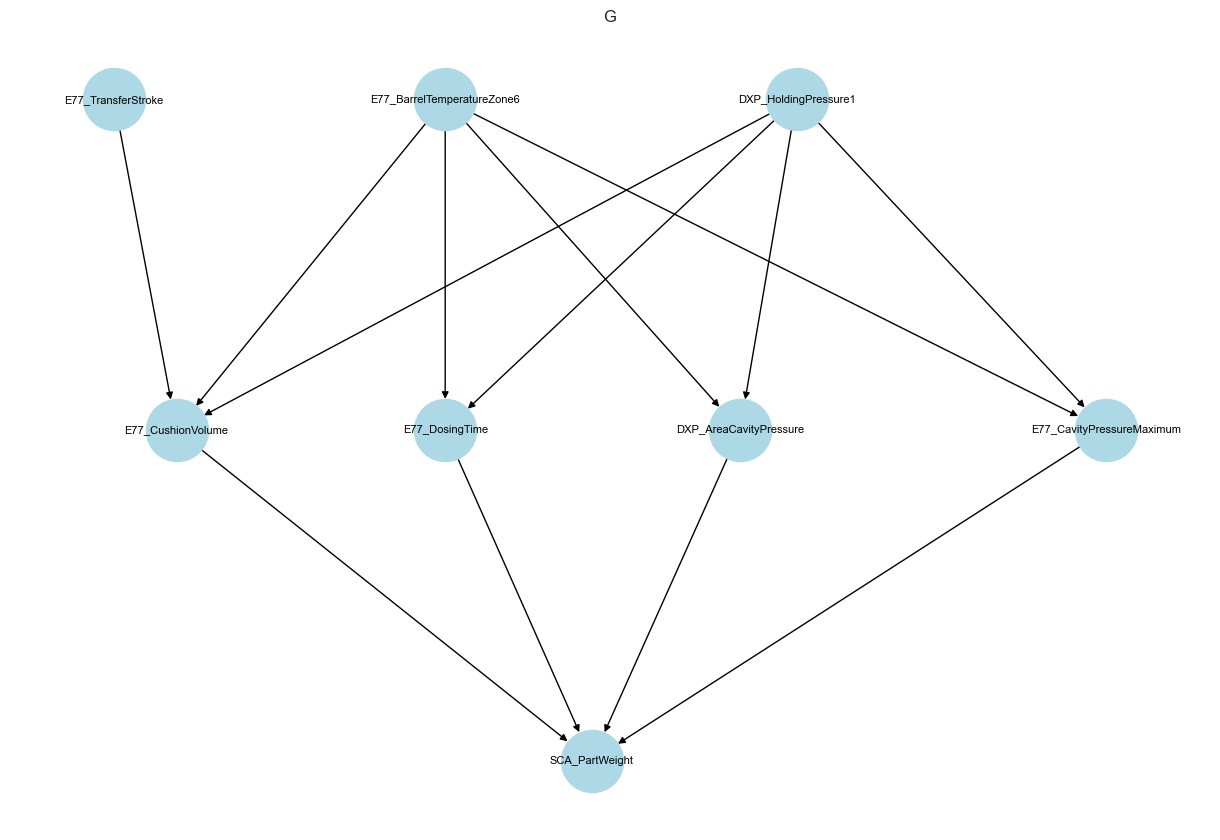

In [4]:
# Graph definition
graph_def_G = """
digraph {
    E77_DosingTime -> SCA_PartWeight;
    E77_CushionVolume -> SCA_PartWeight;
    DXP_AreaCavityPressure -> SCA_PartWeight;
    E77_CavityPressureMaximum -> SCA_PartWeight;
    DXP_HoldingPressure1 -> E77_DosingTime;
    E77_BarrelTemperatureZone6 -> E77_DosingTime;
    DXP_HoldingPressure1 -> E77_CushionVolume;
    E77_BarrelTemperatureZone6 -> E77_CushionVolume;
    E77_TransferStroke -> E77_CushionVolume;
    DXP_HoldingPressure1 -> E77_CavityPressureMaximum;
    E77_BarrelTemperatureZone6 -> E77_CavityPressureMaximum;
    DXP_HoldingPressure1 -> DXP_AreaCavityPressure;
    E77_BarrelTemperatureZone6 -> DXP_AreaCavityPressure;
}
"""

# Create the NetworkX graph from the graph definition
(graph,) = pydot.graph_from_dot_data(graph_def_G)
G = nx.DiGraph(nx.drawing.nx_pydot.from_pydot(graph))

# Visualize the main graph and subgraphs
pos = graphviz_layout(G, prog='dot')
plt.figure(figsize=(12, 8))

# Draw the main graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=8, arrows=True)
plt.title("G")

plt.tight_layout()
plt.show()

# Define Utility Functions

In [5]:
def create_individual_models(data, graph_str, treatment_vars):
    """
    Creates a dictionary of Dowhy CausalModel objects for each treatment.
    """
    models = {}
    for treatment in treatment_vars:
        model = CausalModel(
            data=data,
            graph=graph_str,
            treatment=treatment,
            outcome='SCA_PartWeight'
        )
        models[treatment] = model
    return models

def estimate_effects(models):
    """
    For each model, identifies the effect and estimates it using linear regression.
    Returns dictionaries for effects, identified_estimands, and estimates.
    """
    effects = {}
    identified_estimands = {}
    estimates = {}
    for treatment, model in models.items():
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            warnings.filterwarnings("ignore", category=FutureWarning)
            
            identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
            estimate = model.estimate_effect(
                identified_estimand,
                method_name="backdoor.linear_regression",
                test_significance=True
            )
        
        effects[treatment] = {
            'Estimated Effect': estimate.value,
            'P-value': estimate.test_stat_significance()['p_value']
        }
        identified_estimands[treatment] = identified_estimand
        estimates[treatment] = estimate
    return effects, identified_estimands, estimates

def refute_placebo(models, identified_estimands, estimates, graph_name):
    """
    Performs placebo treatment refutation for each treatment in the given models.
    """
    refutations = {}
    for treatment, model in models.items():
        print(f"\n[Placebo Treatment Refutation] Graph: {graph_name}, Treatment: {treatment}")
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            warnings.filterwarnings("ignore", category=FutureWarning)
            
            identified_estimand = identified_estimands[treatment]
            estimate = estimates[treatment]
            
            refute_result = model.refute_estimate(
                identified_estimand,
                estimate,
                method_name="placebo_treatment_refuter"
            )
        
        print(refute_result)
        refutations[treatment] = {
            'Method': 'Placebo Treatment',
            'Estimated Effect': refute_result.estimated_effect,
            'New Effect': refute_result.new_effect,
            'P-value': refute_result.refutation_result.get('p_value', np.nan)
        }
    return refutations

def refute_random_common_cause(models, identified_estimands, estimates, graph_name):
    """
    Performs random common cause refutation for each treatment in the given models.
    """
    refutations = {}
    for treatment, model in models.items():
        print(f"\n[Random Common Cause Refutation] Graph: {graph_name}, Treatment: {treatment}")
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            warnings.filterwarnings("ignore", category=FutureWarning)
            
            identified_estimand = identified_estimands[treatment]
            estimate = estimates[treatment]
            
            refute_result = model.refute_estimate(
                identified_estimand,
                estimate,
                method_name="random_common_cause"
            )
        print(refute_result)
        refutations[treatment] = {
            'Method': 'Random Common Cause',
            'Estimated Effect': refute_result.estimated_effect,
            'New Effect': refute_result.new_effect,
            'P-value': refute_result.refutation_result.get('p_value', np.nan)
        }
    return refutations

def refute_data_subset(models, identified_estimands, estimates, graph_name, subset_fraction=0.9):
    """
    Performs data subset refutation for each treatment in the given models.
    """
    refutations = {}
    for treatment, model in models.items():
        print(f"\n[Data Subset Refutation] Graph: {graph_name}, Treatment: {treatment}")
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            warnings.filterwarnings("ignore", category=FutureWarning)
            
            identified_estimand = identified_estimands[treatment]
            estimate = estimates[treatment]
            
            refute_result = model.refute_estimate(
                identified_estimand,
                estimate,
                method_name="data_subset_refuter",
                subset_fraction=subset_fraction
            )
        print(refute_result)
        refutations[treatment] = {
            'Method': 'Data Subset',
            'Estimated Effect': refute_result.estimated_effect,
            'New Effect': refute_result.new_effect,
            'P-value': refute_result.refutation_result.get('p_value', np.nan)
        }
    return refutations

def refutations_to_df(refutations):
    """
    Converts a refutations dictionary to a pandas DataFrame.
    """
    return pd.DataFrame.from_dict(refutations, orient='index').reset_index().rename(columns={'index': 'Treatment'})

# Build Causal Models for Graph G

In [6]:
# Define treatment variables of interest
treatment_vars = [
    'E77_CushionVolume',
    'E77_DosingTime',
    'DXP_AreaCavityPressure',
    'E77_CavityPressureMaximum'
]

# Create models for each treatment variable using graph G
models_G = create_individual_models(df, graph_def_G, treatment_vars)

# Estimate effects for the models on graph G
effects_G, identified_estimands_G, estimates_G = estimate_effects(models_G)
print("\nEstimated Effects on Graph G:")
print(pd.DataFrame(effects_G).T)


Estimated Effects on Graph G:
                          Estimated Effect                   P-value
E77_CushionVolume                -0.986497  [1.4316731580013648e-24]
E77_DosingTime                    0.288869   [1.961092337622343e-14]
DXP_AreaCavityPressure           -0.308382  [3.5819404702220483e-31]
E77_CavityPressureMaximum         0.959156   [2.468224048448254e-16]


# Refutation Testing on Graph G

In [7]:
# Placebo Treatment Refutation
refutations_placebo_G = refute_placebo(models_G, identified_estimands_G, estimates_G, 'G')
df_placebo_G = refutations_to_df(refutations_placebo_G)
print("\nPlacebo Treatment Refutation Results:")
print(df_placebo_G)

# Random Common Cause Refutation
refutations_random_G = refute_random_common_cause(models_G, identified_estimands_G, estimates_G, 'G')
df_random_G = refutations_to_df(refutations_random_G)
print("\nRandom Common Cause Refutation Results:")
print(df_random_G)

# Data Subset Refutation
refutations_subset_G = refute_data_subset(models_G, identified_estimands_G, estimates_G, 'G', subset_fraction=0.9)
df_subset_G = refutations_to_df(refutations_subset_G)
print("\nData Subset Refutation Results:")
print(df_subset_G)


[Placebo Treatment Refutation] Graph: G, Treatment: E77_CushionVolume


Refute: Use a Placebo Treatment
Estimated effect:-0.9864965568787236
New effect:-1.7763568394002505e-15
p value:0.0


[Placebo Treatment Refutation] Graph: G, Treatment: E77_DosingTime
Refute: Use a Placebo Treatment
Estimated effect:0.2888694514311141
New effect:-1.7763568394002505e-15
p value:0.0


[Placebo Treatment Refutation] Graph: G, Treatment: DXP_AreaCavityPressure
Refute: Use a Placebo Treatment
Estimated effect:-0.3083819163387749
New effect:-1.7763568394002505e-15
p value:0.0


[Placebo Treatment Refutation] Graph: G, Treatment: E77_CavityPressureMaximum
Refute: Use a Placebo Treatment
Estimated effect:0.9591564306530578
New effect:-1.7763568394002505e-15
p value:0.0


Placebo Treatment Refutation Results:
                   Treatment             Method  Estimated Effect  \
0          E77_CushionVolume  Placebo Treatment         -0.986497   
1             E77_DosingTime  Placebo Treatment          0.288869   
2     DXP_AreaCavityPressure  Placebo Treatment         -0.308382

# Combine Refutation Results and Visualize

In [8]:
# Combine the three refutation results into one DataFrame
df_refutations = pd.concat([df_placebo_G, df_random_G, df_subset_G], ignore_index=True)
print("\nCombined Refutation Results:")
df_refutations


Combined Refutation Results:


,Treatment,Method,Estimated Effect,New Effect,P-value
0,E77_CushionVolume,Placebo Treatment,-0.986497,-1.776357e-15,0.00
1,E77_DosingTime,Placebo Treatment,0.288869,-1.776357e-15,0.00
2,DXP_AreaCavityPressure,Placebo Treatment,-0.308382,-1.776357e-15,0.00
3,E77_CavityPressureMaximum,Placebo Treatment,0.959156,-1.776357e-15,0.00
4,E77_CushionVolume,Random Common Cause,-0.986497,-9.865437e-01,0.96
5,E77_DosingTime,Random Common Cause,0.288869,2.889559e-01,0.84
6,DXP_AreaCavityPressure,Random Common Cause,-0.308382,-3.084294e-01,1.00
7,E77_CavityPressureMaximum,Random Common Cause,0.959156,9.587801e-01,1.00
8,E77_CushionVolume,Data Subset,-0.986497,-9.850733e-01,1.00
9,E77_DosingTime,Data Subset,0.288869,2.890187e-01,0.92


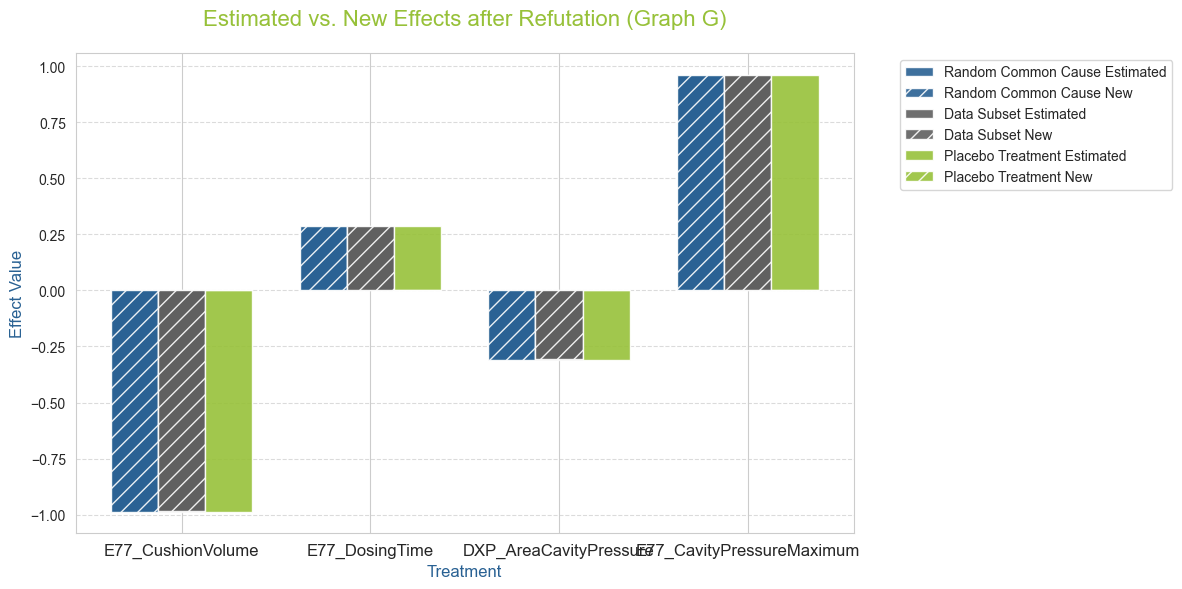

In [9]:
# Visualization 1: Bar Plot comparing Estimated vs. New Effects for each treatment and method

# Define the order for the methods
methods_order = ['Random Common Cause', 'Data Subset', 'Placebo Treatment']

x = np.arange(len(treatment_vars))  # one position per treatment
width = 0.25  # width for each bar

fig, ax = plt.subplots(figsize=(12, 6))

# Define the faps colours for each refutation method
method_colors = {
    'Placebo Treatment': fapsgreen,
    'Random Common Cause': fapsblue,
    'Data Subset': fapsdarkgray
}

for i, method in enumerate(methods_order):
    df_method = df_refutations[df_refutations['Method'] == method]
    # Ensure treatments appear in the same order as in treatment_vars
    df_method = df_method.set_index('Treatment').loc[treatment_vars].reset_index()
    
    # No extra edge styling for any method
    edge_kw = {}
    marker_alpha = 0.9

    # Plot Estimated Effect bars
    ax.bar(x + i * width - width,
           df_method['Estimated Effect'],
           width,
           label=f'{method} Estimated',
           color=method_colors[method],
           alpha=marker_alpha,
           **edge_kw)
    
    # Plot New Effect bars with a hatch pattern for differentiation
    ax.bar(x + i * width - width,
           df_method['New Effect'],
           width,
           label=f'{method} New',
           color=method_colors[method],
           hatch='//',
           alpha=marker_alpha,
           **edge_kw)

# Set labels and title with increased font sizes
ax.set_xlabel('Treatment', fontsize=12, color=fapsblue)
ax.set_ylabel('Effect Value', fontsize=12, color=fapsblue)
ax.set_title('Estimated vs. New Effects after Refutation (Graph G)', fontsize=16, color=fapsgreen, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(treatment_vars, fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

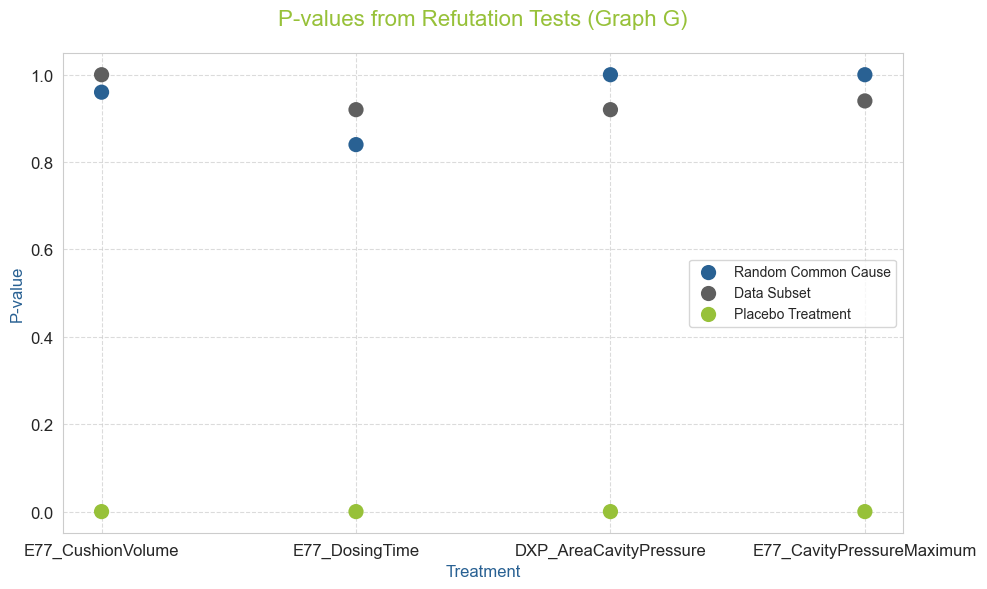

In [10]:
# Visualization 2: Dot Plot of P-values for each refutation method and treatment
fig, ax = plt.subplots(figsize=(10, 6))

for method in methods_order:
    df_method = df_refutations[df_refutations['Method'] == method]
    # Plot all methods with the same marker settings (no special emphasis)
    ax.scatter(df_method['Treatment'],
               df_method['P-value'],
               s=120,
               label=method,
               color=method_colors[method],
               edgecolors='none')

ax.set_xlabel('Treatment', fontsize=12, color=fapsblue)
ax.set_ylabel('P-value', fontsize=12, color=fapsblue)
ax.set_title('P-values from Refutation Tests (Graph G)', fontsize=16, color=fapsgreen, pad=20)
ax.tick_params(labelsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()